In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from scipy.spatial import distance
import os


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.insert(0, "C:\\Dev\\ContourDetectionGCN\\gcn_ultrasound_segmentation")

In [6]:
from data.data_transformers import LeftVentricleUnorderedContour, echonet_trace_to_mask

In [5]:
echonet_path = r"C:\Data\DataGeneration\TestingDatasets\EchoNet-Dynamic"
echonet_pts = pd.read_excel(os.path.join(echonet_path, "VolumeTracings.xlsx"))
echonet_pts.head()


,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC,47.918968,26.754480,62.904129,22.944693,46


## Test out class for conversion

Some notes:
- I found out the best way is to first convert the echonet points to a binary mask and then convert the mask to a contour. There may be another way, but the echonet point ordering throws it off. The LeftVentricleUnorderedContour class can be initialized with either a mask or a contour so it is quite possible to play around with this if you see a better way.
- When converting mask to points it's best to first smooth it than remove some points. The smoothing avoids a choppy mask, while removing some points allows for more accurate angle calculation. See the LeftVentricleunorderedContour class for more. The contour extraction from the mask should also be done with cv2 CHAIN_APPROX_NONE rather than simple so the points will be evenly distributed.
- Apex estimation is done based on distance from the basal points. Basal point estimation is done based on the angle change. The angle calculation can be seen by calling `lvc._get_basal_pts_from_contour(plot=True)` (example below). Note that points around the apex are masked out
- `lvc.to_ordered_contour()` outputs a dictionary where each element is a set of points denoting the contour. By default this dict only contains the myocardium ("myo") but other parts (e.g. "mv" or "all") can also be extracted. See class for details.

In [ ]:
f, axs = plt.subplots(6, 6, figsize=(15, 15))
ind = 0
r_ind = 0
for fname in set(echonet_pts.FileName):
    patient_df = echonet_pts[echonet_pts.FileName==fname]
    for frame in set(patient_df.Frame):
        frame_df = patient_df[patient_df.Frame == frame]
        pts = np.array(frame_df.loc[:, "X1":"Y2"])
        mask = echonet_trace_to_mask(pts, (256, 256))
        lvc = LeftVentricleUnorderedContour(mask=mask)
        lvc.plot(ax=axs[r_ind+0, ind])
        axs[r_ind+0, ind].set_title(f"contour ind {ind}")
        oc = lvc.to_ordered_contour(num_pts=12)["myo"]
        axs[r_ind+1, ind].plot(oc[0], oc[1], "k-o")
        axs[r_ind+1, ind].set_title(f"gcn pts ind {ind}")
        ind += 1
    if ind >= axs.shape[1]:
        ind = 0
        r_ind += 2
    if r_ind >= axs.shape[0]:
        break
for ax in axs.ravel():
    ax.axis("off")

In the above the points are not always evenly distributed, especially in the apex region. This still needs to be fixed.

Also, note that the black point in the upper rows indicates the second point of the contour just to show which direction the contour is moving (it should be the same for all as this is forced in the class initialization)

# Example of how basal points are found
mask masks out points around the apex (mask=1 means masked out)
pt0_mask masks out points around the first basal point for calculation fo the second
angles is the calculated angle of each vector between points

(array([47.99721907, 76.99742137]), array([73.71710844, 74.35761088]))

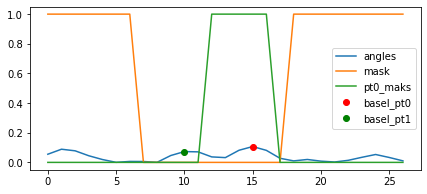

In [59]:
lvc._get_basal_pts_from_contour(plot=True)